# Data decomposition methods
sklearn examples

In [8]:
import logging

import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn import cluster, decomposition
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/Zen/scikit_learn_data
Dataset consists of 400 faces


In [9]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

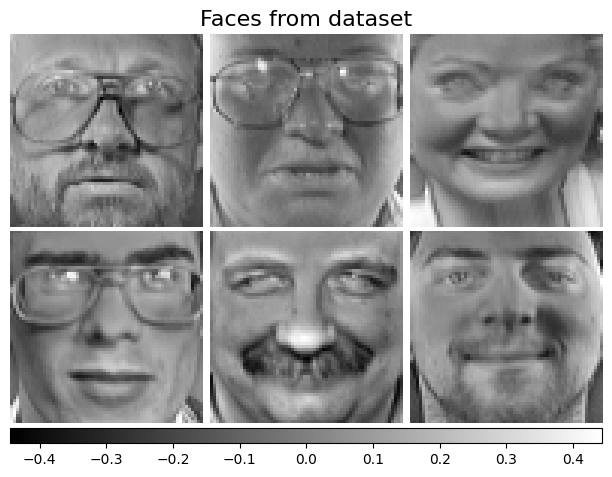

In [10]:
plot_gallery("Faces from dataset", faces_centered[:n_components])

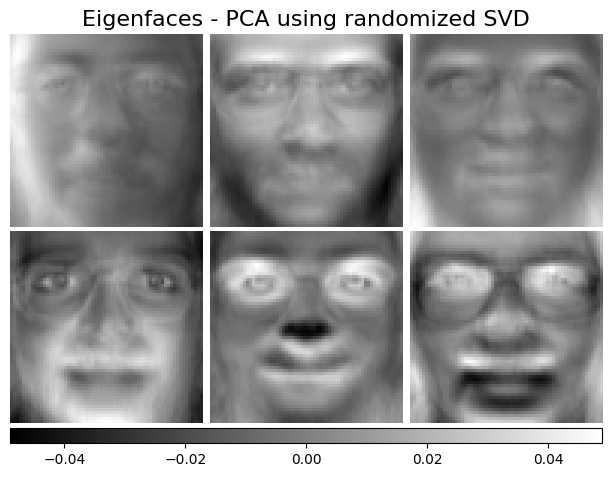

In [11]:
pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="randomized", whiten=True
)
pca_estimator.fit(faces_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

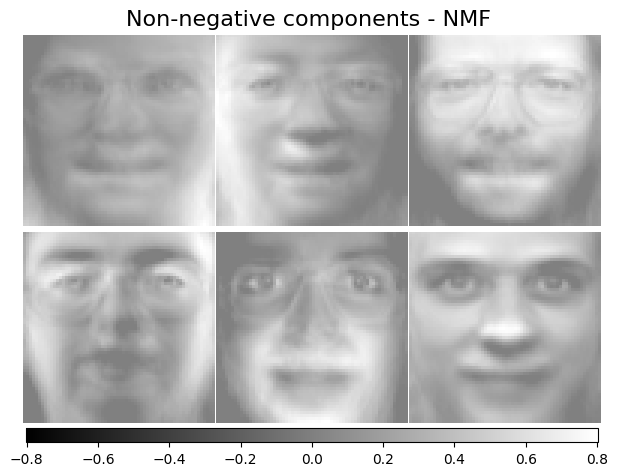

In [12]:
nmf_estimator = decomposition.NMF(n_components=n_components, tol=5e-3)
nmf_estimator.fit(faces)  # original non- negative dataset
plot_gallery("Non-negative components - NMF", nmf_estimator.components_[:n_components])

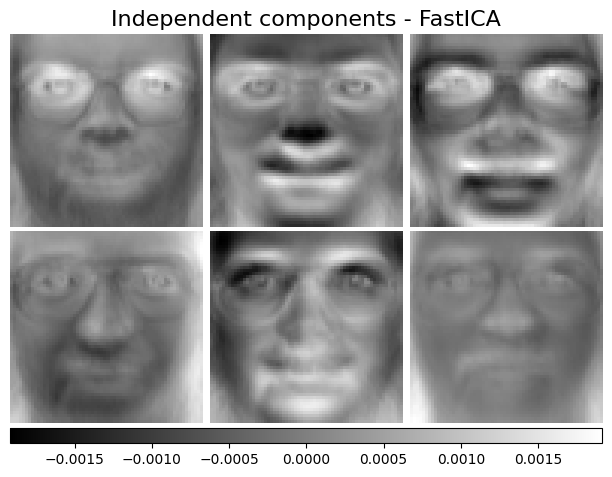

In [13]:
ica_estimator = decomposition.FastICA(
    n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5
)
ica_estimator.fit(faces_centered)
plot_gallery(
    "Independent components - FastICA", ica_estimator.components_[:n_components]
)

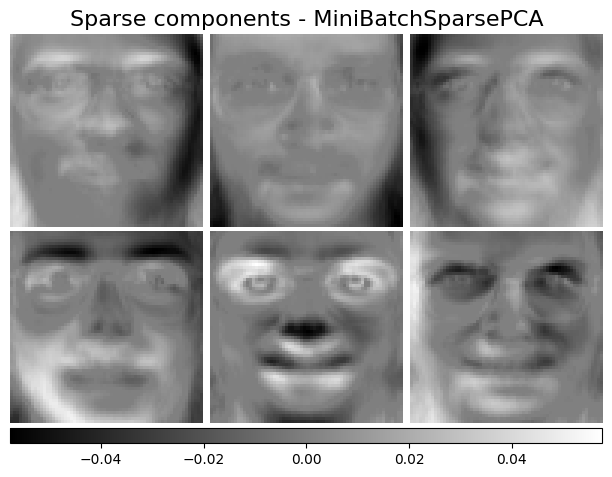

In [14]:
batch_pca_estimator = decomposition.MiniBatchSparsePCA(
    n_components=n_components, alpha=0.1, max_iter=100, batch_size=3, random_state=rng
)
batch_pca_estimator.fit(faces_centered)
plot_gallery(
    "Sparse components - MiniBatchSparsePCA",
    batch_pca_estimator.components_[:n_components],
)

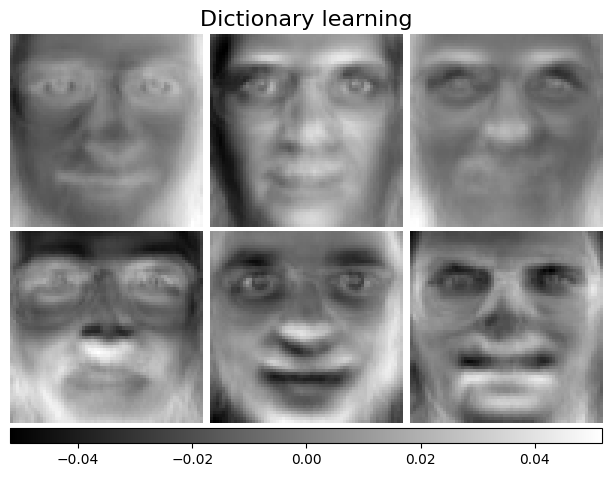

In [15]:
batch_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components, alpha=0.1, max_iter=50, batch_size=3, random_state=rng
)
batch_dict_estimator.fit(faces_centered)
plot_gallery("Dictionary learning", batch_dict_estimator.components_[:n_components])

# PCA uses: Image denoising

In [1]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1_000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

In [3]:
import matplotlib.pyplot as plt


def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

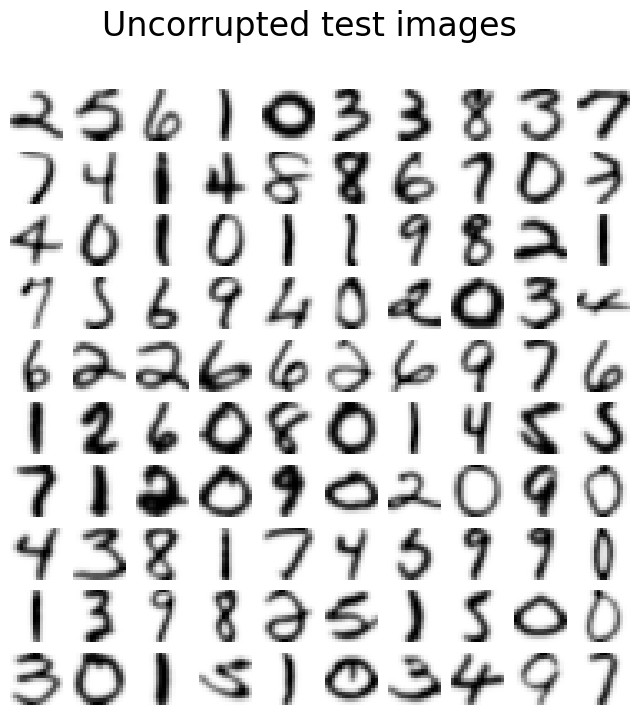

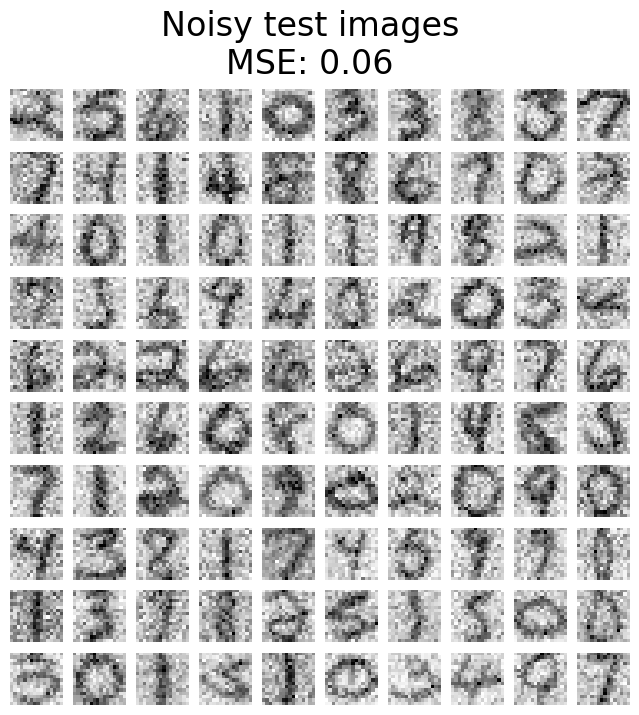

In [4]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_test_noisy, f"Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}"
)

In [5]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=32, random_state=42)
kernel_pca = KernelPCA(
    n_components=400,
    kernel="rbf",
    gamma=1e-3,
    fit_inverse_transform=True,
    alpha=5e-3,
    random_state=42,
)

pca.fit(X_train_noisy)
_ = kernel_pca.fit(X_train_noisy)

In [6]:
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
    kernel_pca.transform(X_test_noisy)
)
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

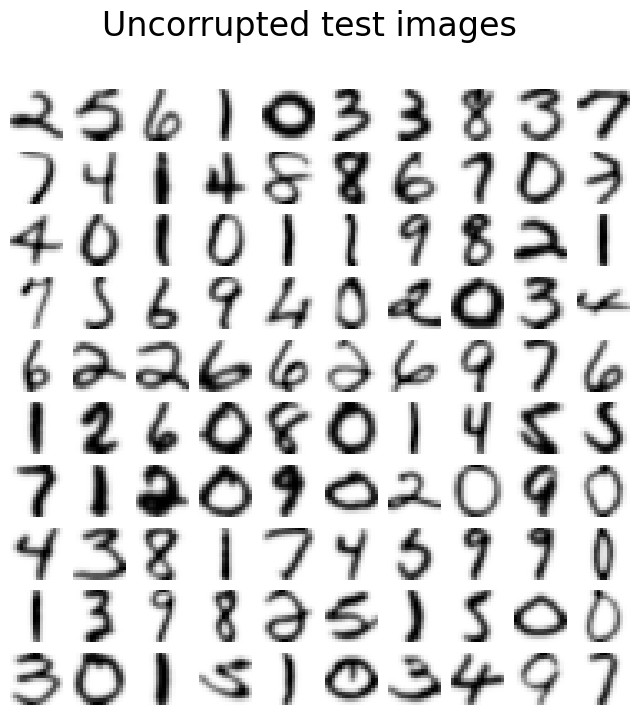

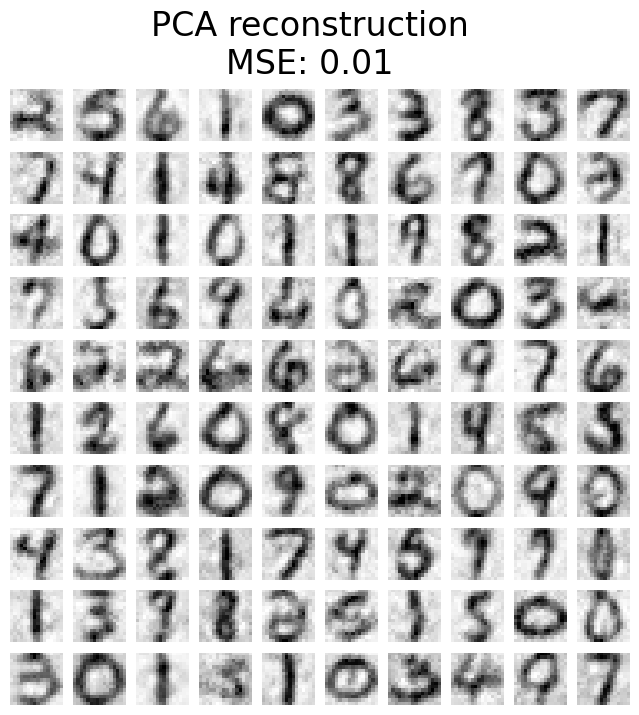

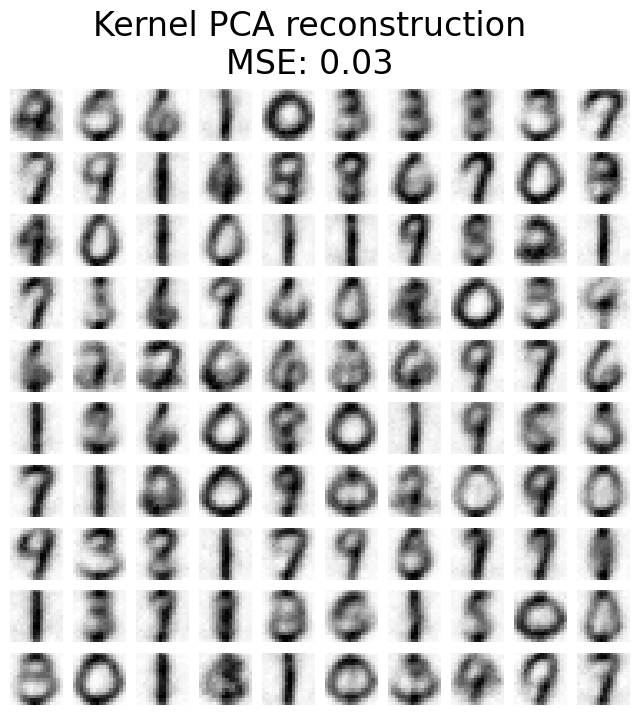

In [7]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_reconstructed_pca,
    f"PCA reconstruction\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}",
)
plot_digits(
    X_reconstructed_kernel_pca,
    (
        "Kernel PCA reconstruction\n"
        f"MSE: {np.mean((X_test - X_reconstructed_kernel_pca) ** 2):.2f}"
    ),
)

# PCA variants

In [16]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

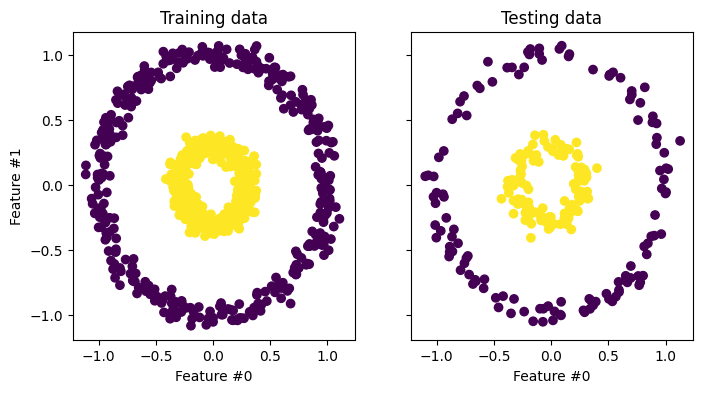

In [17]:
import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [18]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=2)
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_test_pca = pca.fit(X_train).transform(X_test)
X_test_kernel_pca = kernel_pca.fit(X_train).transform(X_test)

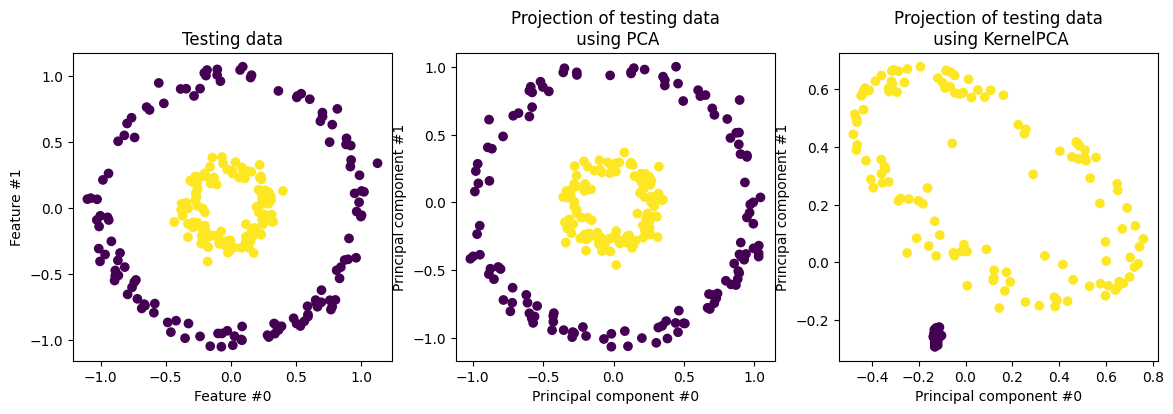

In [19]:
fig, (orig_data_ax, pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=3, figsize=(14, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Testing data")

pca_proj_ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test)
pca_proj_ax.set_ylabel("Principal component #1")
pca_proj_ax.set_xlabel("Principal component #0")
pca_proj_ax.set_title("Projection of testing data\n using PCA")

kernel_pca_proj_ax.scatter(X_test_kernel_pca[:, 0], X_test_kernel_pca[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

In [20]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test))
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(X_test))

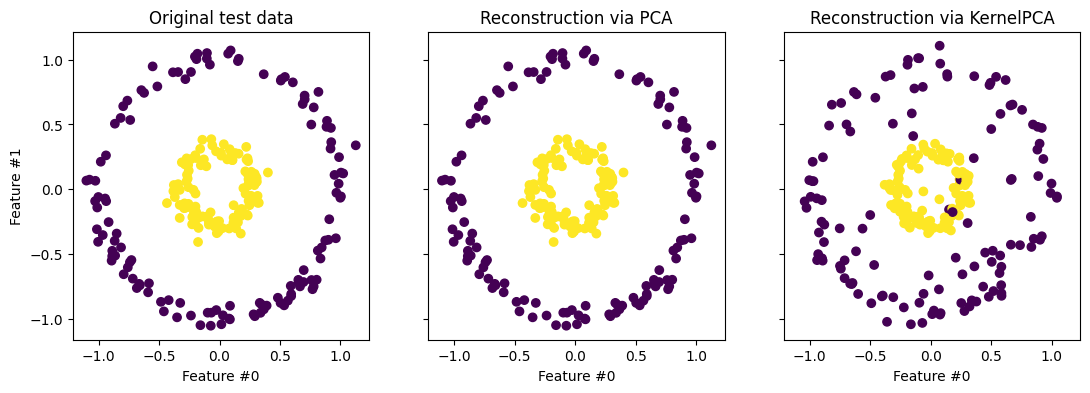

In [21]:
fig, (orig_data_ax, pca_back_proj_ax, kernel_pca_back_proj_ax) = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(13, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Original test data")

pca_back_proj_ax.scatter(X_reconstructed_pca[:, 0], X_reconstructed_pca[:, 1], c=y_test)
pca_back_proj_ax.set_xlabel("Feature #0")
pca_back_proj_ax.set_title("Reconstruction via PCA")

kernel_pca_back_proj_ax.scatter(
    X_reconstructed_kernel_pca[:, 0], X_reconstructed_kernel_pca[:, 1], c=y_test
)
kernel_pca_back_proj_ax.set_xlabel("Feature #0")
_ = kernel_pca_back_proj_ax.set_title("Reconstruction via KernelPCA")

# TSNE examples

circles, perplexity=5 in 0.11 sec
circles, perplexity=30 in 0.15 sec
circles, perplexity=50 in 0.16 sec
circles, perplexity=100 in 0.15 sec
S-curve, perplexity=5 in 0.099 sec
S-curve, perplexity=30 in 0.14 sec
S-curve, perplexity=50 in 0.16 sec
S-curve, perplexity=100 in 0.15 sec
uniform grid, perplexity=5 in 0.15 sec
uniform grid, perplexity=30 in 0.17 sec
uniform grid, perplexity=50 in 0.17 sec
uniform grid, perplexity=100 in 0.16 sec


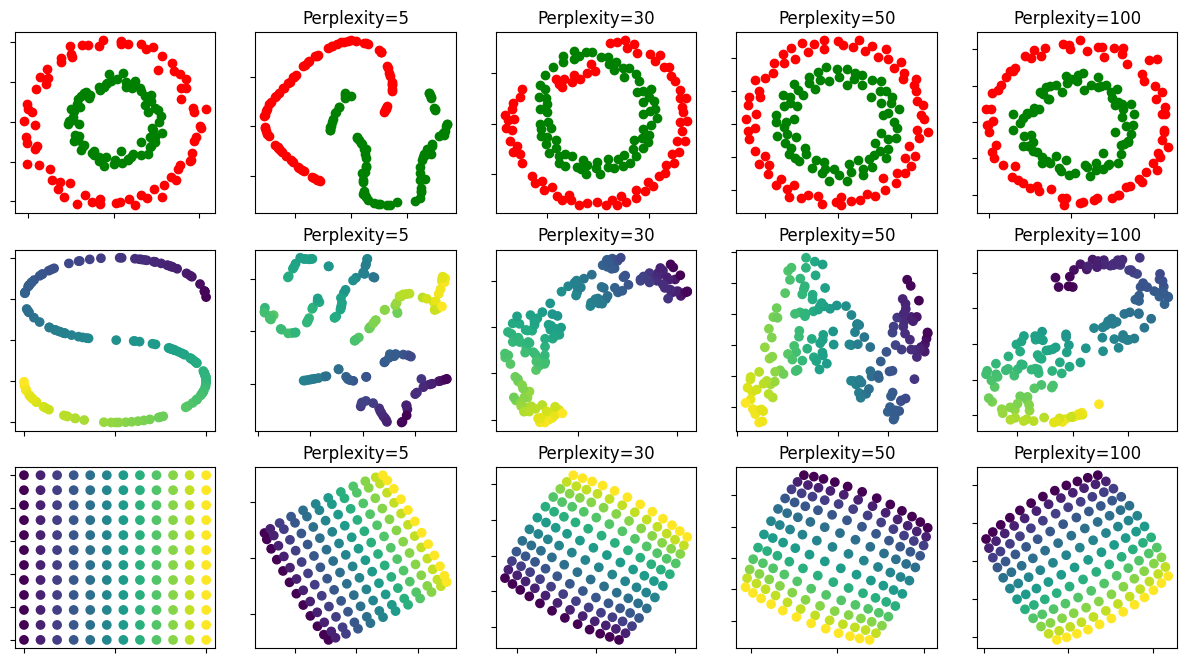

In [1]:
# Author: Narine Kokhlikyan <narine@slice.com>
# License: BSD

from time import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullFormatter

from sklearn import datasets, manifold

n_samples = 150
n_components = 2
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=0
)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        max_iter=300,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

# Another example using s-curve
X, color = datasets.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        learning_rate="auto",
        max_iter=300,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack(
    [
        xx.ravel().reshape(-1, 1),
        yy.ravel().reshape(-1, 1),
    ]
)
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        max_iter=400,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")


plt.show()